In this notebook we reduce the data for a single overlap scan (a lensv or lensh scan), load the reduced data, and fit it to a gaussian

# inputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcslv9618'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/ReducedData/'
# outpath='/reg/d/psdm/xcs/'+exper+'/scratch/slr/'
outpath='/cds/home/s/slraj/code/ScatteringCode/'


Import Complete!


## set up varDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 

        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    


        }

## set up paramDict

In [3]:



paramDict= {
        'binSetup'  : 'unique', #bins are unique values of scan variable
        'binSet2'   : 300,
        'binMethod' : 'ave', 
        'qnorm'     : (2.5,3), 
        'qrange'    : (0.8,3.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 5, # select ipm to use for I0
        'corr_filter' : False,
        'corr_threshold': .03 ,
        'ipm_filter' : (10000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 100, #lower limit for Iscat
    
        'use_TT'   :  False,  
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : False, # ebeam photon energy correction
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        'SVDBackSub': False,
    
    
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,
    
        'showSVD': False, #do svd?
        'SVD_n': 4, # number of svd components
        'slice_plot':None, #how to slice up plots displayed at end
        'smooth':None, #smoothing before svd?
        
        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
    
    }

# Run Reduction

loading  /reg/d/psdm/xcs/xcslv9618/hdf5/smalldata/xcslv9618_Run0244.h5
basename is  xcslv9618_Run0244
scan variable is  lens_h
finished loading h5
calculated Iscat
setupFilters - done!
2.2769107818603516  seconds
saved reduction.png
using scan_vector for binning axis


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:98: RuntimeWarning: Mean of empty slice
  darkMean = np.nanmean(dark,0)


x-ray off subtraction done!
normalize data


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:297: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(cspad_azav[early_x,:,:]/normal_factor[early_x,None,None],0) #normalize by norm


normalize data done!
starting difference signal
Difference Signal Done!
10.578910827636719  seconds
Starting binning
bin by unique x axis value
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!
12.181863069534302  seconds
saved output to /cds/home/s/slraj/code/ScatteringCode/npy/xcslv9618_Run0244_out.npy
16854/25259 events used
plotting azavs
logscan False
(21, 535)
(535,)
done
12.747879028320312  seconds


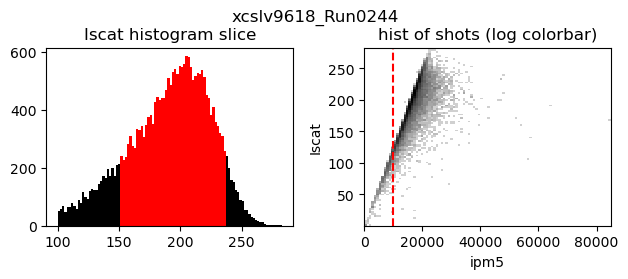

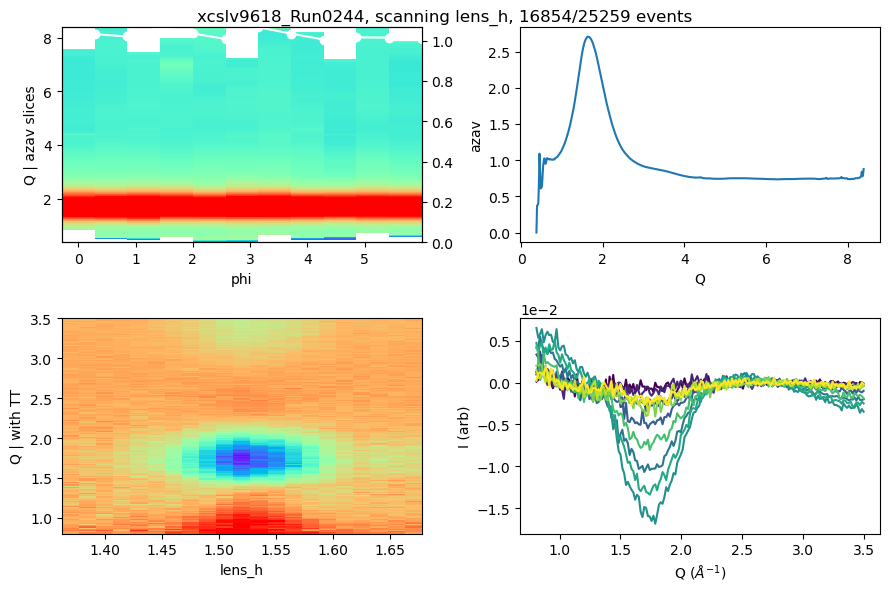

In [4]:
runs=[244]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Load Data and Fit Gaussian

In [5]:
def gaus(x, a, b, c, d):
    return a * np.exp(-1*(x-b)**2/2/c**2) + d

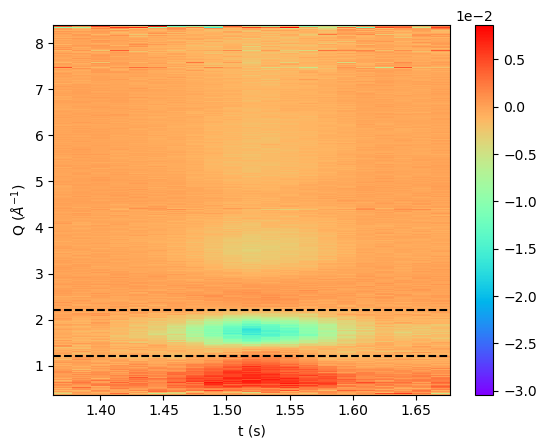

In [6]:
## fit q vs lens_h with gaussian and extract fwhm 
runnum=244
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum

qrange=(1.2,2.2)            

data= np.load(filepath,allow_pickle= True).item()

qs=data['qs']
phis=data['phis'][0:-1]
scanvar=data['xcenter']
diff=data['diff_bin']

goodq = np.where((qs > qrange[0]) & (qs < qrange[1]))[0]
diff2d=np.nanmean(diff,1)#average over phis
plt.figure('scanvar2')
plot_2d(scanvar,qs,diff2d,fig='scanvar2')
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
# plt.clim(-5e-2,5e-2)
diff1d=np.nanmean(diff2d[:,goodq],1)

Text(0.5, 0.98, "('run=', 244, 'center=', 1.526086136034677, 'fwhm=', 0.10091235558432722, 'qrange', (1.2, 2.2))")

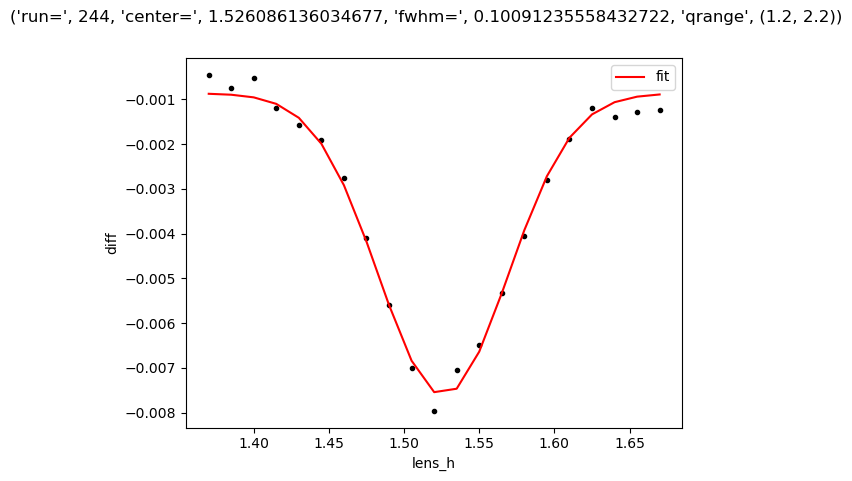

In [7]:

# lens_v=True
lens_v=False

if lens_v:
    p0=[.005,.05,.05,0.001] #lensv
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

    center=param[1]
    fwhm=param[2]*2.355
    
else:
    p0=[-.008,1.54,0.01,-0.001]
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

#     param, err =curve_fit(gaus,scanvar,diff1d)

center=param[1]
fwhm=param[2]*2.355

plt.figure('fit')
plt.plot(scanvar,diff1d,'k.')
plt.plot(scanvar,gaus(scanvar,*param),'r',label='fit')
if lens_v:
    plt.xlabel('lens_v')
else:
    plt.xlabel('lens_h')
plt.ylabel('diff')
plt.legend()
plt.suptitle(('run=',runnum,'center=',center,'fwhm=',fwhm,'qrange',qrange))

In [8]:
from scipy.special import erf

def stepfn(x, A,x0,sigma,B):
    return (A/2*erf((x0-x)/sigma)+B)

In [9]:
runnum=62
qrange=(2.2,2.4)
trange=(-2e-12,2e-12)

filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum
# filepath='/reg/d/psdm/xcs/xcsx51920/results/ReferenceData/xpp00316_water_data.npy'

data= np.load(filepath,allow_pickle= True).item()
print(data.keys())

qs=data['qs']
ts=data['xcenter']
# S2=data['S2']
S2=data['S0']

# qs=data['q'].squeeze()
# ts=data['Delays'].squeeze()
# S2=data['AllTTDelayS2'].T


goodq=np.nonzero((qrange[0]<qs) & (qs<qrange[1]))
S2slice=np.nanmean(S2[:,goodq].squeeze(),axis=1)
# S2slice=np.nansum(S2[:,goodq].squeeze(),axis=1)

goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
S2slice2=S2slice[goodt].squeeze()

plt.figure('S2slice1',figsize=(15,8))
plot_2d(ts[goodt].squeeze(),qs,S2[goodt,:].squeeze(),fig='S2slice1',sub=121)
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
# plt.xlabel('lxe_opa')


plt.subplot(122)
plt.plot(ts,S2slice)
# plt.xlabel('lxe_opa')
plt.axvline(trange[0],ls='--',color='k')
plt.axvline(trange[1],ls='--',color='k')


FileNotFoundError: [Errno 2] No such file or directory: '/cds/home/s/slraj/code/ScatteringCode//npy/xcslv9618_Run0062_out.npy'

In [ ]:

p0=[0.002,0,.08,-.0002] #initial guesses
param, err =curve_fit(stepfn,ts[goodt].squeeze(),S2slice2,p0=p0)

center=param[1]
fwhm=param[2]*2.355
print('x0=',center,'fwhm',fwhm)


plt.figure('fit')
plt.plot(ts[goodt],S2slice2)
plt.plot(ts[goodt],stepfn(ts[goodt],*param),label='fit')


In [ ]:
def exp1(x,A,x0,tau,C):
    return A*np.e**((-1.)*(x-x0)/tau)+C

def exp2(x,A,x0,tau):
    return A*np.e**((-1.)*(x-x0)/tau)

In [ ]:
trange=(-1.e-12,10e-12)
goodt=np.nonzero((trange[0]<ts) & (ts<trange[1]))
qrange=(0.5,4)
goodq=np.nonzero((qrange[0]<qs) & (qs<qrange[1]))

ss,ww,tt=do_svd_protected(qs[goodq],ts[goodt],S0[goodt,:].squeeze()[:,goodq].squeeze(),n=4,smooth=None,showplot=True, fig=None, sub=None,logscan=False)

In [ ]:
t1=ww[0]*tt[:,0]

p0=[-0.6,0.01e-12,4e-12,-0.6] #initial guesses
param, err =curve_fit(exp1,ts[goodt],t1,p0=p0)


plt.figure('fit')
plt.plot(ts[goodt],t1)
plt.plot(ts[goodt],exp1(ts[goodt],*param),label='fit')

print(param)

In [ ]:
runpath=outpath+'npy/'
runs2=[71,72]

stackDict=StackProccessed(runpath,exper,runs2,method='bincount')

In [ ]:
## save stack
outname=exper+'Stack_65_to_70'

np.save(outpath+'/stack_npy/'+outname+'.npy',stackDict)

In [ ]:
plot_2d(ts,qs,np.nanmean(diff,1).T)

In [ ]:

print(stackDict.keys())
diff=stackDict['aveData']
ts=stackDict['ts']
qs=stackDict['qs']
phis=stackDict['phis']

# S0, err_S0, S2, err_S2=S0S2(diff,phis,fil=None,shift_n=1,deg=None)
# outdict=SnFitT(2,diff,qs,phis[:-1],1.3051,shift_n=1)

In [ ]:
outdict.keys()

S2=outdict['Sn'][:,:,0]

In [ ]:
outdict['Sn'].shape

In [ ]:
plot_2d(ts,qs,S2)
plt.clim(-1e-3,1e-3)

In [ ]:
run = 23
smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'

fname=smalldata_folder+ exper+'_Run%04i.h5'%run


with h5py.File(fname, 'r') as d:
    pp='epix_1'
    # pp=''
    # pp='/diodeGon/'
    
    for a in d[pp]:
        try: 
            print(a,d[pp][a][:].shape)
        except:
            print(a)
      
    
    lxt=d['epics/lxt'][:]
    lxt_fast=d['enc/lasDelay'][:]
    laserP=d['/diodeGon/channels/'][:,0]
    filterP = laserP>(np.nanmean(laserP)-np.nanstd(laserP)*3)
    # dropx=d['epix_1/ragged_droplet_photon_i'][:]
    # lxe_opa=d['scan/lxe_opa'][:]
    # var0=d['scan/var0'][:]
    # varStep=d['scan/varStep'][:]
    print('okay','\n')
    print(d['ebeam/photon_energy'][0])
    # print(d['UserDataCfg/epix10k2M/azav__azav_qbins'].shape)
    # ttCorr=d['tt/ttCorr'][:]
    # fltpos=d['tt/FLTPOS'][:]


    # azav=d['epix10k2M/azav_azav'][:]
    # ipm4=d['ipm4/sum'][:]
    # ipm5=d['ipm4/sum'][:]
    # ImSum=d['Sums/epix10k2M_calib'][:]
    # Npix=d['UserDataCfg/epix10k2M/azav__azav_Cake_Npixel'][:]
    # qs=d['UserDataCfg/epix10k2M/azav__azav_q'][:]
    # phis=d['UserDataCfg/epix10k2M/azav__azav_phiVec'][:]

    # Isum=np.nanmean(azav,(1,2))
# pos=np.array([xx,yy])


In [ ]:
lxt_fast